In [122]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [123]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [124]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [125]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [126]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [127]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [128]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [129]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [130]:
#inspect the DB 
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [131]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [132]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [133]:
# Find the most recent date in the data set
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [134]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_12_date = "2016-08-23"

# Perform a query to retrieve the data and precipitation scores
last12months = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_12_date).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last12months, columns=['date', 'precipitation'])
df = df.set_index("date")

# Sort the dataframe by date
df = df.sort_values(by = ['date'])

#drop null values
df = df.dropna()
df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


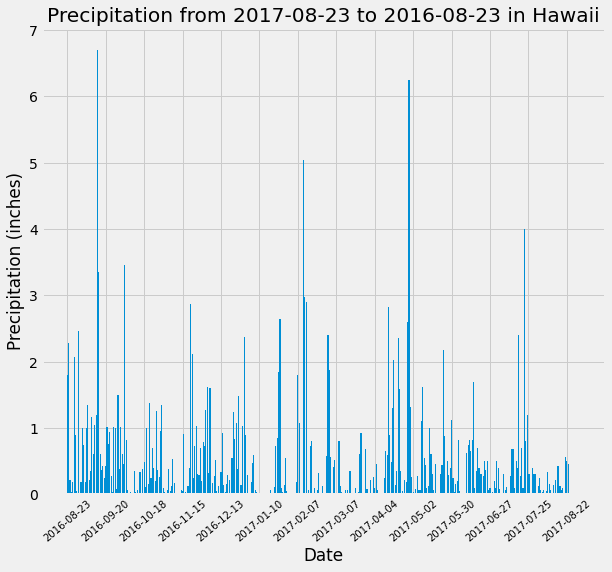

In [143]:
# Use Pandas Plotting with Matplotlib to plot the data
x = df.index.tolist()
y = df["precipitation"].tolist()

plt.figure(figsize=(9,8))

plt.bar(x,y)

plt.title(f"Precipitation from 2017-08-23 to {last_12_date} in Hawaii")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

x_ticks = np.arange(0, 400,28)
plt.xticks(x_ticks,  rotation=40, fontsize = 10);

#save image to images folder 
plt.savefig('Images/12_months_precipitation_data', bbox_inches="tight")

#display graph to screen 
plt.show()

In [136]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [137]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).count()
total_stations

9

In [138]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_freq = session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [139]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# I used engine.execute method just to try something different here 

most_active_data = engine.execute('SELECT MIN(measurement.tobs), MAX(measurement.tobs), AVG(measurement.tobs) FROM measurement WHERE measurement.station = "USC00519281" GROUP BY measurement.station').fetchall()

print(f"For the most active station, station ID: {station_freq[0][0]}:")
print(f"The highest temperature recorded: {most_active_data[0][0]}")
print(f"The lowest temperature recorded: {most_active_data[0][1]}")
print(f"The average temperature: {most_active_data[0][2]}")


For the most active station, station ID: USC00519281:
The highest temperature recorded: 54.0
The lowest temperature recorded: 85.0
The average temperature: 71.66378066378067


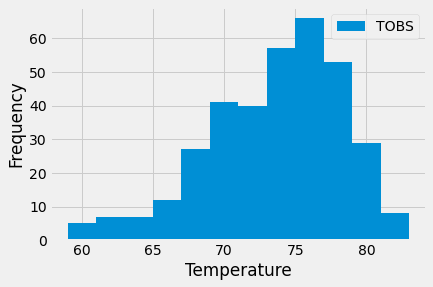

In [147]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_last_12 = session.query(measurement.tobs).filter(measurement.date >= last_12_date).filter(measurement.station == 'USC00519281').all()
most_active_last_12
active_df = pd.DataFrame(most_active_last_12, columns=['TOBS'])
active_df.plot.hist(bins = 12)
plt.xlabel("Temperature");


#save image to images folder 
plt.savefig('Images/most_active_station_histogram', bbox_inches="tight")

#display graph to screen 
plt.show()

# Close session

In [148]:
# Close Session
session.close()